In [1]:
# идея модели в том, что значительная часть изменения ВВП
# детерминирована изменением количества трудоспособного населения
# что повышает точность прогнозирования.
# модель берёт за основу следующую связь:
# изменение_ВВП = изменение_трудоспособного_населения * изменение_производительности_труда
# где нам известен первый множитель,
# так как всё будущее трудоспособное население к текущему дню уже родилось
# и легко поддаётся прогнозированию

In [2]:
%matplotlib inline

import pandas as pd
import matplotlib
from matplotlib.ticker import FuncFormatter
from matplotlib import pyplot as plt
from pprint import pprint
from statistics import mean 

def to_percent(y, position):
    s = str(100 * y)
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

In [3]:
YEARS_HISTORY = [i for i in range(1990, 2018, 1)]
YEARS_FORECAST = [i for i in range(2018, 2041, 1)]
YEARS_ALL = YEARS_HISTORY + YEARS_FORECAST

In [4]:
# READ DATASETS FROM WORLDBANK

df_pop = pd.read_csv('population_estimates.csv')
df_gdp = pd.read_csv('gdp.csv')

# CONVERT YEAR-COLUMN-NAMES FROM STRING TO INTEGERS

df_pop.columns = [int(i) if i.isdigit() else i for i in df_pop.columns]
df_pop.head()

# POPULATION DATA SAMPLE BELOW:

,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,...,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040
0,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,"87,4813398865699","86,7261782925178","86,0581180690568","84,9067498061564","83,5981421599692","81,9464190070822",...,"56,099647590667","55,7075749910587","55,3786633487538","55,0961406363375","54,8521130154695","54,7110232796612","54,5938649678594","54,5137941567587","54,4820837065065","54,5009738006491"
1,Arab World,ARB,"Age dependency ratio, old",SP.POP.DPND.OL,"6,73251809748213","6,78084775154971","6,87209344706523","6,90916114081667","6,94144048296085","6,93159691710332",...,"10,0175139127664","10,2789280948965","10,5489012487375","10,8286920572129","11,1198770509465","11,4109162653524","11,7069378981572","12,014316308486","12,3399690006757","12,6881860400338"
2,Arab World,ARB,"Age dependency ratio, young",SP.POP.DPND.YG,"79,9948301216975","79,1869996355888","78,4706873295225","77,2639846330442","75,8967427873421","74,1768412734498",...,"45,0563102673158","44,4368958917695","43,874643332954","43,3526195634956","42,8606955788711","42,4694758849668","42,0991075065111","41,7570766335065","41,4471051882669","41,1662878127329"
3,Arab World,ARB,"Age population, age 0, female, interpolated",SP.POP.AG00.FE.IN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arab World,ARB,"Age population, age 0, male, interpolated",SP.POP.AG00.MA.IN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_gdp.columns = [int(i) if i.isdigit() else i for i in df_gdp.columns] 
df_gdp.head()

# GDP DATA SAMPLE BELOW:

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,"GDP, PPP (constant 2011 international $)",NY.GDP.MKTP.PP.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.671232e+09,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,"GDP, PPP (constant 2011 international $)",NY.GDP.MKTP.PP.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,3.543156e+10,4.287950e+10,4.649566e+10,4.933825e+10,5.646010e+10,5.866237e+10,6.024070e+10,6.102987e+10,6.247428e+10,6.409582e+10
2,Angola,AGO,"GDP, PPP (constant 2011 international $)",NY.GDP.MKTP.PP.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.300848e+11,1.332237e+11,1.378237e+11,1.431621e+11,1.505744e+11,1.608778e+11,1.684455e+11,1.734984e+11,1.720870e+11,1.733290e+11
3,Albania,ALB,"GDP, PPP (constant 2011 international $)",NY.GDP.MKTP.PP.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.697909e+10,2.788359e+10,2.891809e+10,2.965555e+10,3.007665e+10,3.037764e+10,3.091665e+10,3.160261e+10,3.266198e+10,3.391665e+10
4,Andorra,AND,"GDP, PPP (constant 2011 international $)",NY.GDP.MKTP.PP.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# DEFINE INTERESTED COUNTRIES

COUNTRIES = ['European Union',
             'China',
             'United States',
             'India',
             'Latin America & Caribbean',
             'Sub-Saharan Africa',
             'Japan',
             'Middle East & North Africa',
             'Russian Federation',
             'Canada',
             'Australia',
             'World']

# DEFINE CODES OF INTERESTED AGE GROUPS (25-69 YO). OTHER AGES DON'T PRODUCE VALUE ADDED IN GENERAL, SO NOT INTERESTING TO OBSERVE

CODES = ['SP.POP.2529.', 'SP.POP.3034.', 'SP.POP.3539.', 'SP.POP.4044.', 'SP.POP.4549.', 'SP.POP.5054.', 'SP.POP.5559.', 'SP.POP.6064.', 'SP.POP.6469.']
CODES = [i + 'MA' for i in CODES] + [i + 'FE' for i in CODES]  # male + female

In [7]:
# FORM POPULATION (25-69) DICTIONARY FROM RAW-DATAFRAME

population = {country: {year: 0 for year in YEARS_ALL} for country in COUNTRIES}
for index, row in df_pop.iterrows():
    country = row['Country Name']
    code = row['Indicator Code']
    if country in COUNTRIES and code in CODES:
        for year in YEARS_ALL:
            population[country][year] += float(row[year])

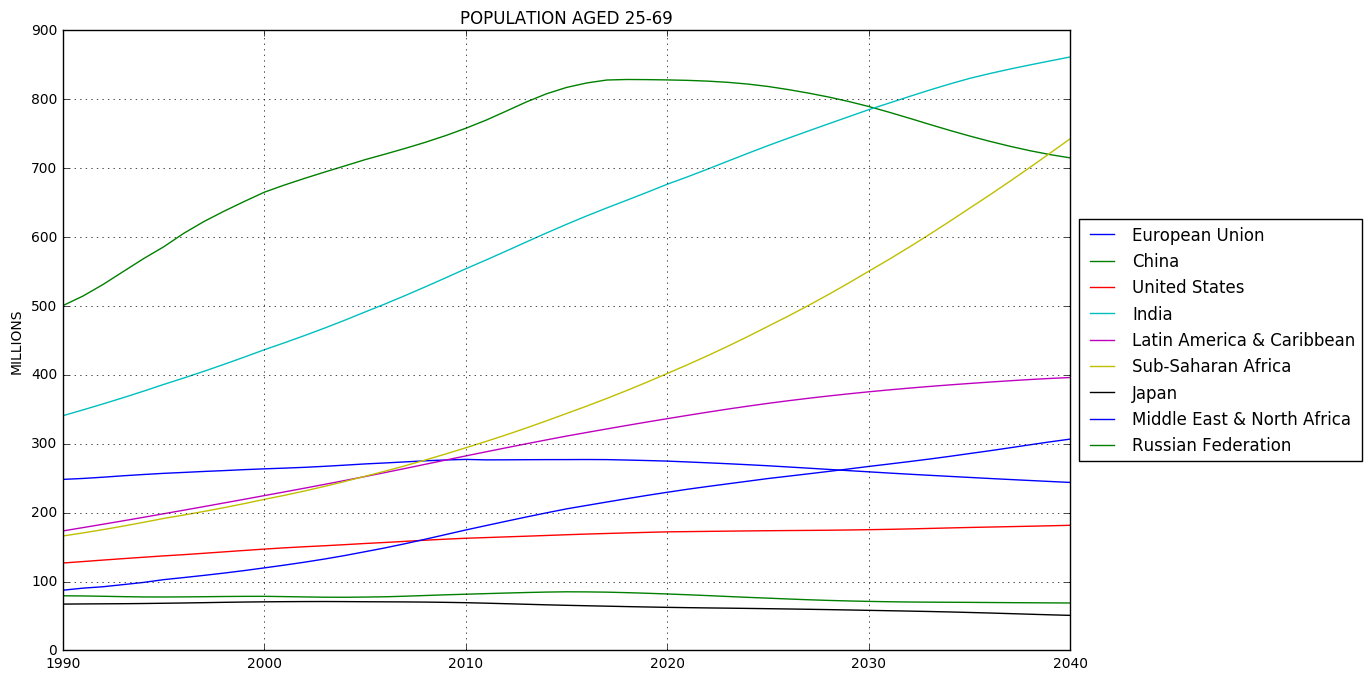

In [49]:
plt.figure(figsize=[13, 8])
[plt.plot(YEARS_ALL, [i/10**6 for i in population[country].values()], label=country) for country in COUNTRIES[:-3]]
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.title('POPULATION AGED 25-69')
plt.ylabel('MILLIONS');

In [25]:
# FORM GDP DICTIONARY FROM RAW-DATAFRAME
gdp = {row['Country Name']: {year: row[year] for year in YEARS_HISTORY} for index, row in df_gdp.iterrows() if row['Country Name'] in COUNTRIES}

# CALC GDP PER CAPITA (25-69 only)
gdp_per_cap = {country: {year: (gdp[country][year]/population[country][year]) for year in YEARS_HISTORY} for country in COUNTRIES}

# CALC PER CAPITA YEARLY GROWTH
gdp_per_cap_growth = {country: {year: gdp_per_cap[country][year]/gdp_per_cap[country][year - 1] for year in YEARS_HISTORY if year != 1990} for country in COUNTRIES}

print u'Средний рост подушевого ВВП (1990-2017):\n'
pprint({country: str((mean(gdp_per_cap_growth[country].values()) - 1) * 100)[:4] + '%' for country in COUNTRIES})

print '\nСредний рост подушевого ВВП (2012-2017):\n'
pprint({country: str((mean(gdp_per_cap_growth[country].values()[-6:]) - 1) * 100)[:4] + '%' for country in COUNTRIES})

Средний рост подушевого ВВП (1990-2017):

{'Australia': '1.51%',
 'Canada': '1.19%',
 'China': '7.71%',
 'European Union': '1.36%',
 'India': '4.16%',
 'Japan': '1.19%',
 'Latin America & Caribbean': '0.57%',
 'Middle East & North Africa': '0.27%',
 'Russian Federation': '0.60%',
 'Sub-Saharan Africa': '0.99%',
 'United States': '1.33%',
 'World': '1.44%'}

Средний рост подушевого ВВП (2012-2017):

{'Australia': '1.26%',
 'Canada': '1.27%',
 'China': '5.93%',
 'European Union': '1.42%',
 'India': '4.64%',
 'Japan': '2.42%',
 'Latin America & Caribbean': '-0.2%',
 'Middle East & North Africa': '0.08%',
 'Russian Federation': '0.34%',
 'Sub-Saharan Africa': '0.44%',
 'United States': '1.57%',
 'World': '1.76%'}


In [63]:
# FORECAST GROWTH FOR 2018 - 2040
# строить какие-нибудь кривые нет нужды, так как текущим значениям особо некуда изменяться
# и на прогноз ввп принципиально не влияют, за исключением Китая и Индии

for country in COUNTRIES:
    for year in YEARS_FORECAST:
        if country in ['European Union', 'Australia', 'Canada']:
            gdp_per_cap_growth[country][year] = 1.014
        if country == 'United States':
            gdp_per_cap_growth[country][year] = 1.016
        if country == 'China':
            # Не самый оптимистичный сценарий,
            # но он выше чем у экономико-политических конкурентов
            gdp_per_cap_growth[country][year] = (gdp_per_cap_growth[country][year - 1] - 1) * 0.9 + 1.0015
        if country == 'India':
            # Индия имеет низкий подушевой ВВП и благодаря эффекту низкой базы он может быстро расти (Китай-стайл)
            gdp_per_cap_growth[country][year] = gdp_per_cap_growth[country][year - 1]
        if country == 'Japan':
            gdp_per_cap_growth[country][year] = 1.015
        if country == 'Latin America & Caribbean':
            gdp_per_cap_growth[country][year] = 1.01
        if country == 'Middle East & North Africa':
            gdp_per_cap_growth[country][year] = 1.01
        if country == 'Russian Federation':
            gdp_per_cap_growth[country][year] = 1.01
        if country == 'World':
            gdp_per_cap_growth[country][year] = 1.015
        if country == 'Sub-Saharan Africa':
            # порадуем ребят и возьмём что-нить получше
            gdp_per_cap_growth[country][year] = 1.015


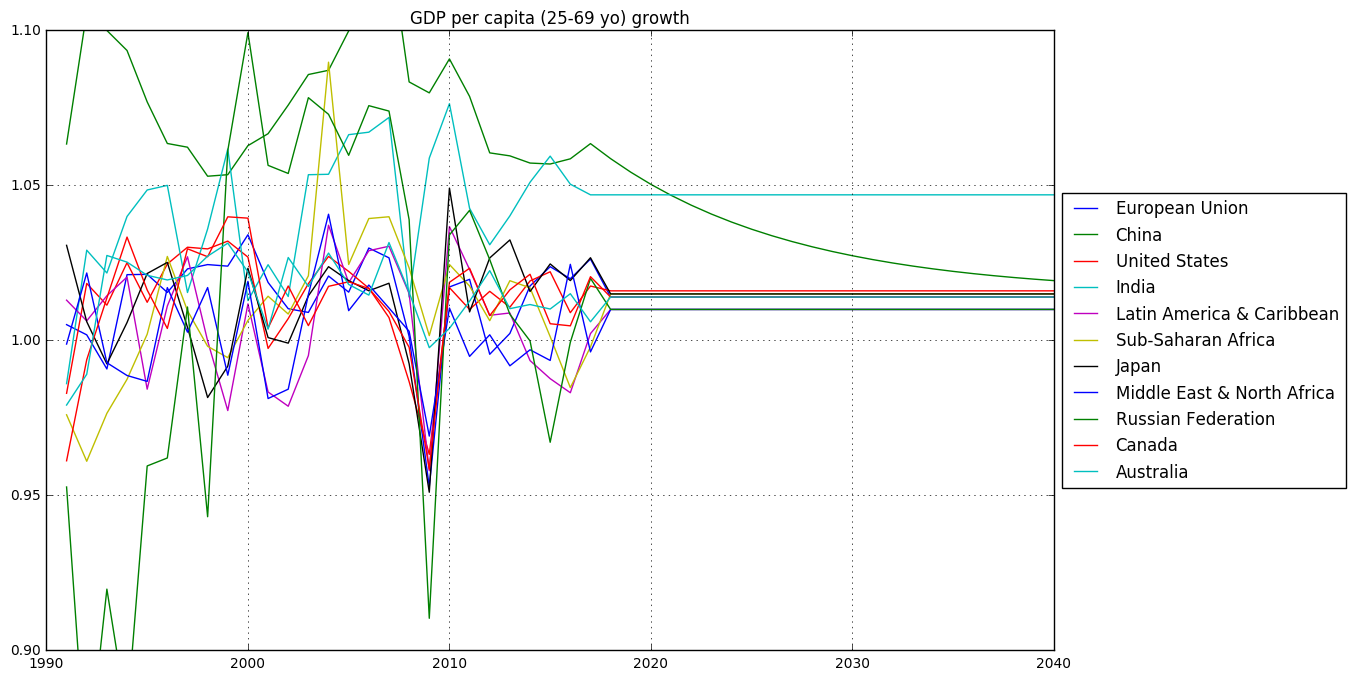

In [64]:
# PLOT GDP PER CAPITA GROWTH

plt.figure(figsize=[13, 8])
[plt.plot(YEARS_ALL[1:], gdp_per_cap_growth[country].values(), label=country) for country in COUNTRIES[:-1]]
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(top=1.1, bottom=0.9)
plt.title('GDP per capita (25-69 yo) growth')
plt.grid()

In [65]:
# CALC GDP PER CAPITA FOR 2018 - 2040 WITH FORECASTED DATA

for country in COUNTRIES:
    for year in YEARS_FORECAST:
        gdp_per_cap[country][year] = gdp_per_cap[country][year - 1] * gdp_per_cap_growth[country][year]

# CALC GDP FOR 2018 - 2040 WITH FORECASTED DATA

gdp = {country: {year: gdp_per_cap[country][year] * population[country][year] for year in YEARS_ALL} for country in COUNTRIES}

In [66]:
gdp['Other'] = dict()
gdp['Other Western'] = dict()

# CALC GDP FOR ALL OTHER COUNTRIES
gdp['Other'] = {year: (gdp['World'][year] - sum([gdp[country][year] for country in COUNTRIES[:-1]])) for year in YEARS_ALL}
# SUM GDP FOR AUSTRALIA AND CANADA TO NEW CATEGORY "OTHER WESTERN"
gdp['Other Western'] = {year: gdp['Australia'][year] + gdp['Canada'][year] for year in YEARS_ALL}

del gdp['Australia']
del gdp['Canada']

In [67]:
# NORMALIZE DATA FOR CHART WITH Y=[0;1]

gdp_normalized = {country: {year: gdp[country][year] / gdp['World'][year] for year in YEARS_ALL} for country in COUNTRIES[:-3] + ['Other'] + ['Other Western']}

Хуже всех смотрится Европа (3 снизу) - имхо, ребята не очень поклоняются деньгам (читай ВВП),
а фокусируются больше на социальных и гуманистических категориях. Их экономика в последнее десятилетие смотрится хуже американской, оттого и такой сценарий.

У Индии (2 снизу) есть высокий потенциал, который, как она показала, может реализовывать.


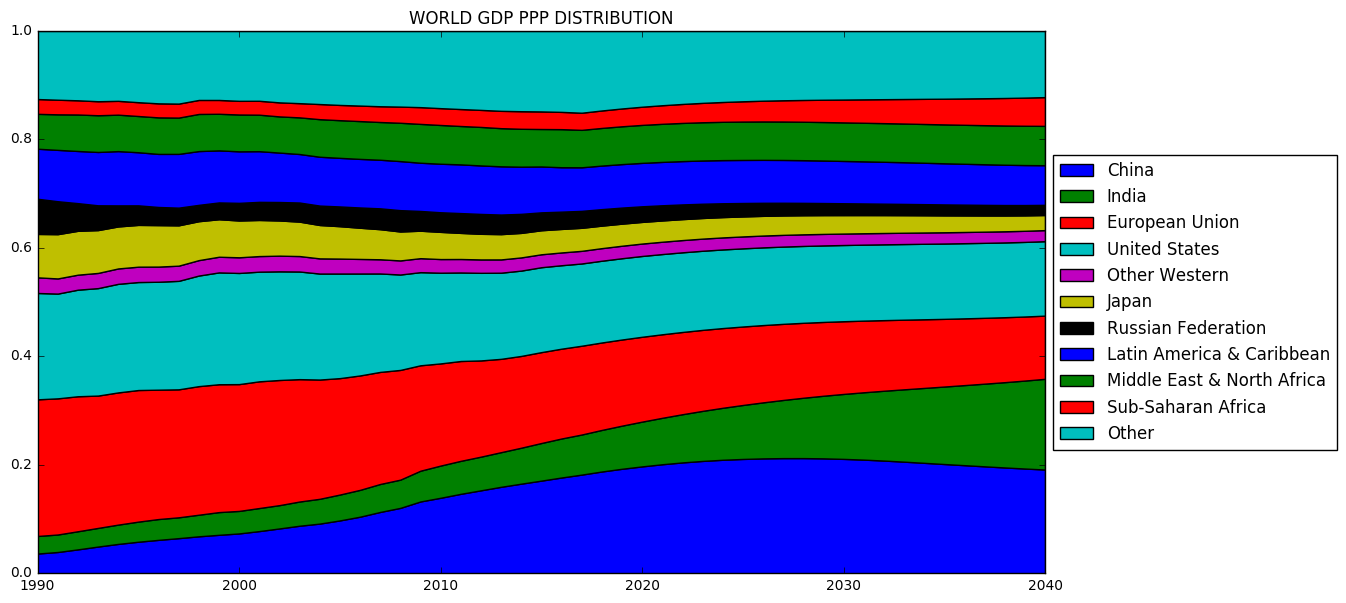

In [68]:
plt.figure(figsize=[13, 7])
plt.stackplot(YEARS_ALL,
              gdp_normalized['China'].values(),
              gdp_normalized['India'].values(),
              gdp_normalized['European Union'].values(),
              gdp_normalized['United States'].values(),
              gdp_normalized['Other Western'].values(),
              gdp_normalized['Japan'].values(),
              gdp_normalized['Russian Federation'].values(),
              gdp_normalized['Latin America & Caribbean'].values(),
              gdp_normalized['Middle East & North Africa'].values(),
              gdp_normalized['Sub-Saharan Africa'].values(),
              gdp_normalized['Other'].values(),
              labels=['China', 'India', 'European Union', 'United States', 'Other Western', 'Japan', 'Russian Federation', 'Latin America & Caribbean', 'Middle East & North Africa', 'Sub-Saharan Africa', 'Other'])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('WORLD GDP PPP DISTRIBUTION')
plt.ylim(top=1);
print u"""Хуже всех смотрится Европа (3 снизу) - имхо, ребята не очень поклоняются деньгам (читай ВВП),
а фокусируются больше на социальных и гуманистических категориях. Их экономика в последнее десятилетие смотрится хуже американской, оттого и такой сценарий.\n
У Индии (2 снизу) есть высокий потенциал, который, как она показала, может реализовывать."""

Китай имеет шансы пройти свой пик мировой доли ВВП в 2020-х при условии умеренно быстрого роста Индии


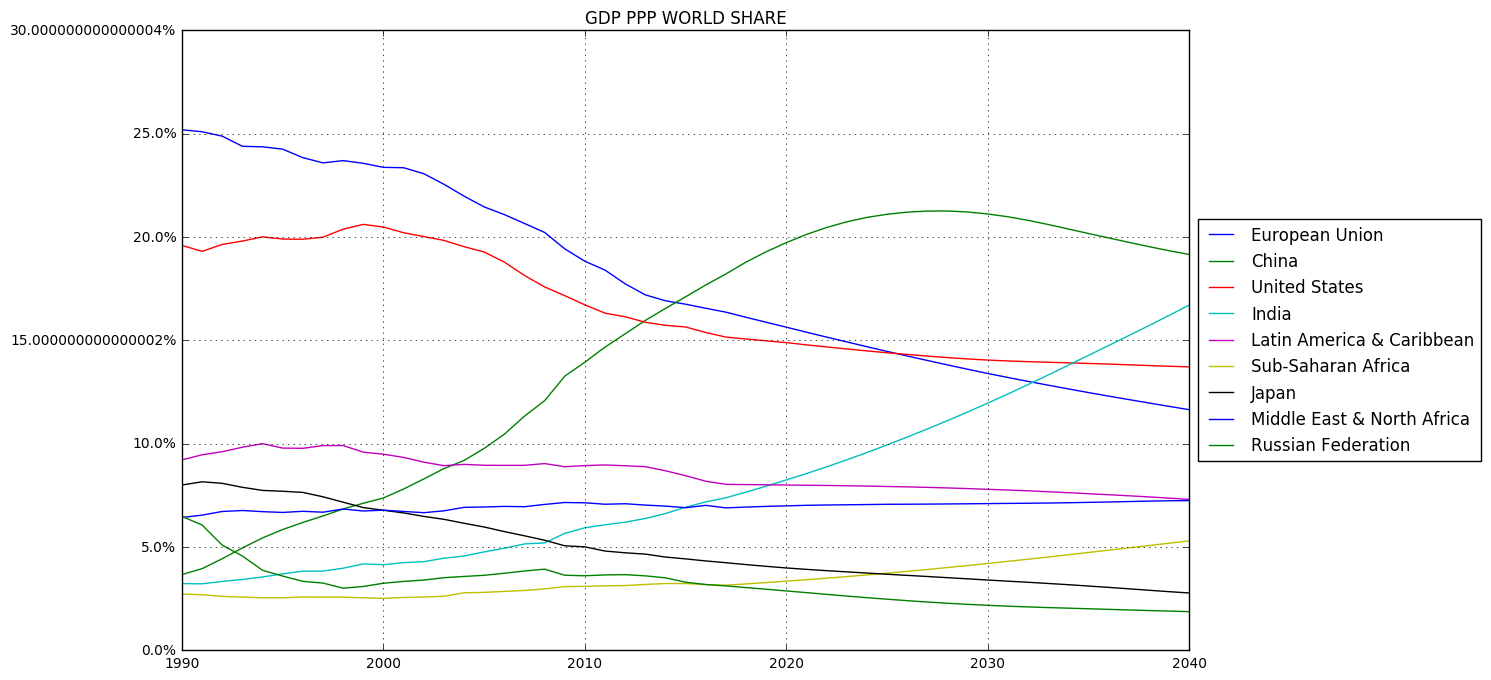

In [69]:
plt.figure(figsize=[13, 8])
[plt.plot(YEARS_ALL, gdp_normalized[country].values(), label=country) for country in COUNTRIES[:-3]]
formatter = FuncFormatter(to_percent)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.title('GDP PPP WORLD SHARE')
plt.gca().yaxis.set_major_formatter(formatter)
print u'Китай имеет шансы пройти свой пик мировой доли ВВП в 2020-х при условии умеренно быстрого роста Индии'

Основная причина будущего расхождения ВВП США и Европы - динамика населения


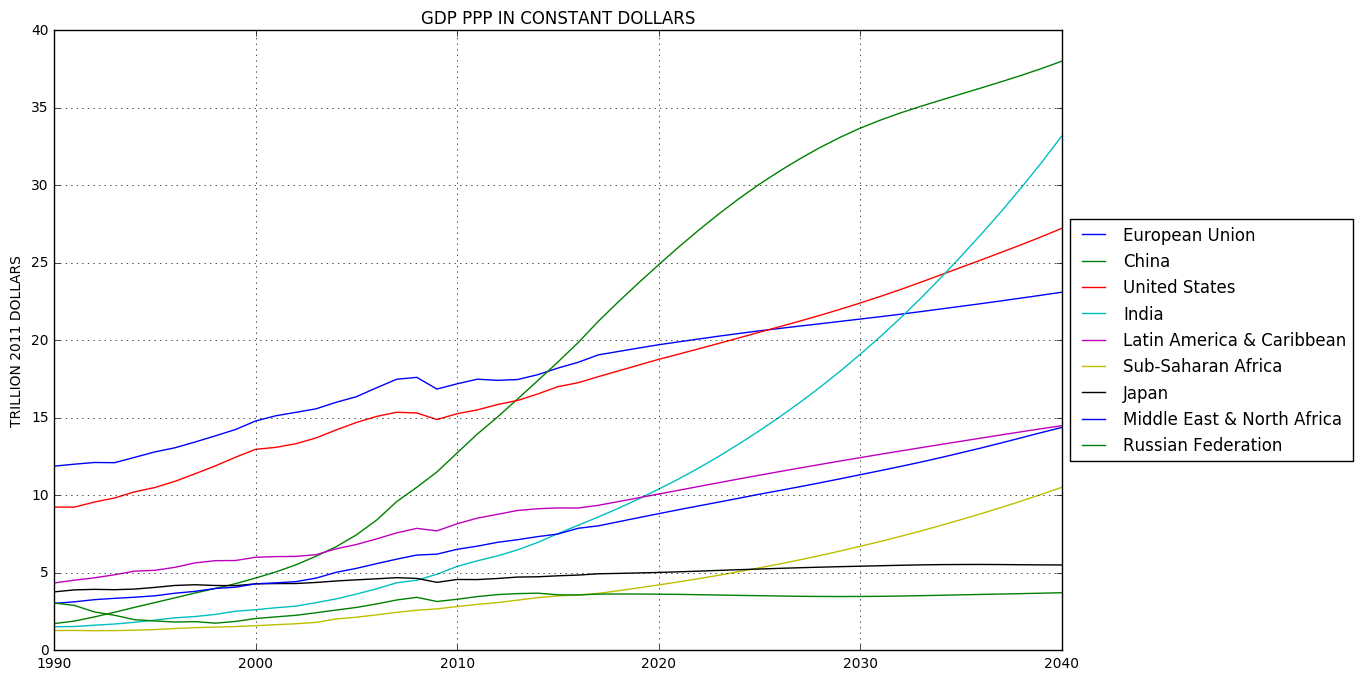

In [71]:
plt.figure(figsize=[13, 8])
[plt.plot(YEARS_ALL, [i/10**12 for i in gdp[country].values()], label=country) for country in COUNTRIES[:-3]]
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.title('GDP PPP IN CONSTANT DOLLARS')
plt.ylabel('TRILLION 2011 DOLLARS');
print u'Основная причина будущего расхождения ВВП США и Европы - динамика населения'